In [77]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as stats
from itertools import product
from concurrent.futures import ThreadPoolExecutor
import concurrent

filename = 'agent_log_28'

x_max = 400
y_max = 400
z_max = 50

no_of_samples = 16
r = 6
d = 50

In [78]:
df = pd.read_csv("output/" + filename + ".csv")
data = df[df["tick"] == df["tick"].max()]
data = data.reset_index(drop=True)

In [79]:
def systematic_regular(no_of_samples, x, y):
    # Calculate the dimensions of the regular grid
    rows = int(np.sqrt(no_of_samples))
    cols = int(np.ceil(no_of_samples / rows))

    # Calculate the padding to ensure points are equally spaced
    padding_x = (x - (rows - 1)) // rows
    padding_y = (y - (cols - 1)) // cols

    # Initialize points list
    points = []

    # Select equally spaced points with padding
    for i in range(rows):
        for j in range(cols):
            points.append((int((i * (padding_x + 1)) + ((padding_x + 1)/2)), int((j * (padding_y + 1) + ((padding_y + 1)/2)))))

    return points[:no_of_samples]

def systematic_random(no_of_samples, x, y):
    # Calculate the dimensions of the regular grid
    rows = int(np.sqrt(no_of_samples))
    cols = int(np.ceil(no_of_samples / rows))

    # Calculate the padding to ensure points are equally spaced
    padding_x = (x - (rows - 1)) // rows
    padding_y = (y - (cols - 1)) // cols

    # Initialize points list
    points = []
    x_range = range(int(-(padding_x + 1)/2), int((padding_x + 1)/2))
    y_range = range(int(-(padding_y + 1)/2), int((padding_y + 1)/2))

    # Select equally spaced points with padding
    for i in range(rows):
        for j in range(cols):
            x_offset = np.random.choice(x_range)
            y_offset = np.random.choice(y_range)
            points.append((int((i * (padding_x + 1)) + ((padding_x + 1)/2) + x_offset), int((j * (padding_y + 1) + ((padding_y + 1)/2)) + y_offset)))

    return points[:no_of_samples]

def default_random(no_of_samples, x, y):
    # Initialize points list
    points = []
    x_range = range(x)
    y_range = range(y)

    # Select equally spaced points with padding
    for _ in range(no_of_samples):
        x_coord = np.random.choice(x_range)
        y_coord = np.random.choice(y_range)
        points.append((x_coord, y_coord))

    return points[:no_of_samples]

def wageningen_w():
    return [(50, 50), (50, 150), (50, 250), (50, 350), (125, 150), (175, 250), (275, 150), (225, 250), (350, 50), (350, 150), (350, 250), (350, 350)]
    

In [80]:
def retrieve_ids_per_sample_von_neumann(points, data, r, d):
    samples =  [ [] for _ in range(len(points)) ]
    for ind, row in data.iterrows():
        for index, point in enumerate(points):
            x1, y1 = point
            x2 = row.x
            y2 = row.y
            z2 = row.z

            if (z2 <= d) and ((abs(x1 - x2) + abs(y1 - y2)) <= r):
                samples[index].append(ind)
    return samples

def retrieve_ids_per_sample_chebyshev(points, data, r, d):
    samples =  [ [] for _ in range(len(points)) ]
    for ind, row in data.iterrows():
        for index, point in enumerate(points):
            x1, y1 = point
            x2 = row.x
            y2 = row.y
            z2 = row.z

            # Calculate the Chebyshev distance between point1 and point2
            chebyshev_distance = max(abs(x1 - x2), abs(y1 - y2))

            # Check if point2 lies within the Von Neumann neighborhood of point1 within range r
            if (z2<=d) and (chebyshev_distance <= r):
                samples[index].append(ind)
    return samples 

Selected points: [(50, 50), (50, 150), (50, 250), (50, 350), (150, 50), (150, 150), (150, 250), (150, 350), (250, 50), (250, 150), (250, 250), (250, 350), (350, 50), (350, 150), (350, 250), (350, 350)]
Simulated samples: [[189, 643, 792, 968, 2154, 2758], [446, 491, 897, 1143, 2160, 2951, 4192, 4239], [94, 205, 375, 539, 1936], [443, 1914, 3777], [], [178, 564, 4199], [1734], [572, 1020, 1141, 1313, 2041, 2450, 4262], [4832], [4859, 5773, 6212, 6516, 8155, 8678], [5972, 9105, 10176], [6240, 6427, 6730, 7732, 7999, 8008, 8818, 9188], [4651, 9727], [5997, 6227, 6523, 8686], [5173, 6011, 6308, 7071], [5055, 6184, 6674, 6789]]


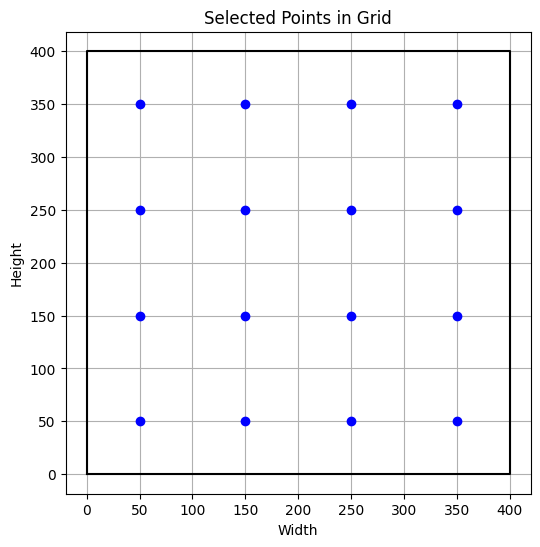

In [81]:
x_max = 400
y_max = 400
z_max = 50

no_of_samples = 16
r = 6
d = 50

selected_points = systematic_regular(no_of_samples, x_max, y_max)
#selected_points = systematic_random(no_of_samples, x_max, y_max)
#selected_points = default_random(no_of_samples, x_max, y_max)
#selected_points = wageningen_w()
samples = retrieve_ids_per_sample_von_neumann(selected_points, data, r, d)

print("Selected points:", selected_points)
print("Simulated samples:", samples)

# Plotting the points in a grid
plt.figure(figsize=(6, 6))
plt.plot([0, x_max, x_max, 0, 0], [0, 0, y_max, y_max, 0], 'k-')  # Plot grid boundaries
for ind, point in enumerate(selected_points):
    plt.plot(point[0], point[1], 'bo')#, markersize=(0.1 * len(samples[ind])))  # Plot selected points
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Selected Points in Grid')
plt.grid(True)
plt.axis('equal')
plt.show()

In [82]:
sample_site_counts = []
for sample_site in samples:
    df2 = data.iloc[sample_site]
    count = df2['type'].value_counts().reindex(range(len(df["type"].unique())), fill_value=0)
    sample_site_counts.append([val for _, val in count.items()])


In [83]:
def pearson_cooccurrence(abundance_data, threshold=0):
    # Initialize a graph
    G = nx.Graph()
    G.add_nodes_from(range(12))

    # Calculate the Pearson correlation coefficient matrix
    pearson_matrix = np.corrcoef(abundance_data, rowvar=False)
    
    pearson_matrix[np.isnan(pearson_matrix)] = 0

    # Get the number of entities
    num_entities = len(abundance_data[0])

    # Iterate through the Pearson correlation matrix to create co-occurrence edges
    for i in range(num_entities):
        for j in range(i + 1, num_entities):
            # Check if the correlation coefficient exceeds the threshold
            if (pearson_matrix[i][j] > threshold):
                G.add_edge(i, j, weight=pearson_matrix[i][j])

    return G, pearson_matrix

def spearman_cooccurrence(abundance_data, threshold=0):
    # Initialize a graph
    G = nx.Graph()
    G.add_nodes_from(range(12))
    
    # Calculate the Pearson correlation coefficient matrix
    spearman_matrix = stats.spearmanr(abundance_data).statistic
    spearman_matrix[np.isnan(spearman_matrix)] = 0
    # Get the number of entities
    num_entities = len(abundance_data[0])

    # Iterate through the Pearson correlation matrix to create co-occurrence edges
    for i in range(num_entities):
        for j in range(i + 1, num_entities):
            # Check if the correlation coefficient exceeds the threshold
            if (spearman_matrix[i][j] > threshold):
                G.add_edge(i, j, weight=spearman_matrix[i][j])

    return G, spearman_matrix

/home/timovdk/soil_sim/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/timovdk/soil_sim/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


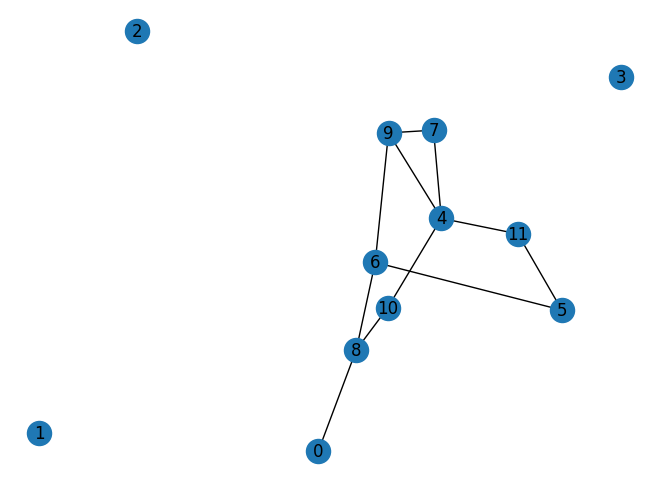

In [84]:
pearson_net, pearson = pearson_cooccurrence(sample_site_counts, 0)

nx.draw(pearson_net, with_labels=True)

In [85]:
def manhattan_distance(point1, point2):
    """
    Computes the Manhattan distance between two points in 3D space.
    """
    return np.abs(point1[0] - point2[0]) + np.abs(point1[1] - point2[1]) + np.abs(point1[2] - point2[2])


def calculate_counts(entity_type, entity_instances, entities):
    """
    Calculate the counts of other types in the Von Neumann neighborhood for a given type.
    """
    counts = np.zeros(12, dtype=int)
    for other_type, other_instances in entities.items():
        if entity_type != other_type:
            for entity_instance, other_instance in product(entity_instances, other_instances):
                if manhattan_distance(entity_instance, other_instance) <= 1:
                    counts[other_type] += 1
    return counts

def count_von_neumann_neighborhood_parallel(df):
    """
    Counts the occurrences of each type in the 3D Von Neumann neighborhood of each type in parallel.
    """
    entities = df.groupby('type').apply(lambda x: list(zip(x['x'], x['y'], x['z'])), include_groups=False).to_dict()

    with ThreadPoolExecutor() as executor:
        future_to_type = {executor.submit(calculate_counts, entity_type, entity_instances, entities): entity_type
                          for entity_type, entity_instances in entities.items()}
        neighborhood_counts = np.zeros((12, 12), dtype=int)
        for future in concurrent.futures.as_completed(future_to_type):
            entity_type = future_to_type[future]
            counts = future.result()
            neighborhood_counts[entity_type] = counts
    
    return neighborhood_counts

/home/timovdk/soil_sim/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/timovdk/soil_sim/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


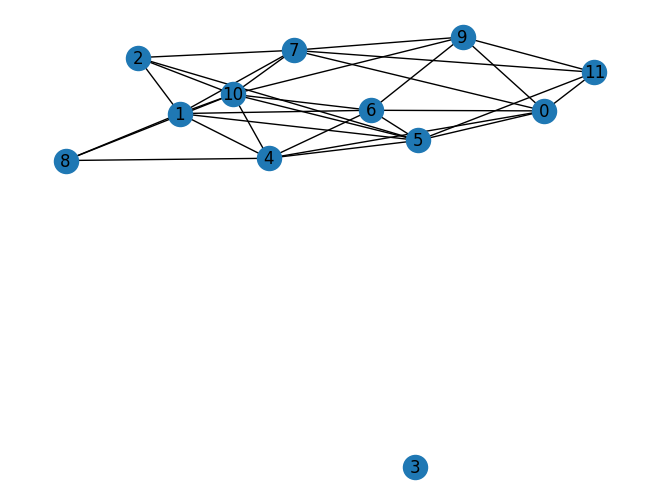

In [86]:
neighborhood_counts = count_von_neumann_neighborhood_parallel(data)

gt_pearson_net, gt_pearson = pearson_cooccurrence(neighborhood_counts, 0)

nx.draw(gt_pearson_net, with_labels=True)

In [87]:
def frobenius_norm(matrix1, matrix2):
    """
    Compute the Frobenius norm between two matrices.
    
    Args:
    - matrix1: First correlation matrix (numpy array)
    - matrix2: Second correlation matrix (numpy array)
    
    Returns:
    - norm: Frobenius norm between the two matrices
    """
    difference_matrix = matrix1 - matrix2
    norm = np.linalg.norm(difference_matrix, ord='fro')
    return norm

In [88]:
frobenius_norm(pearson, gt_pearson)

4.107238141490101

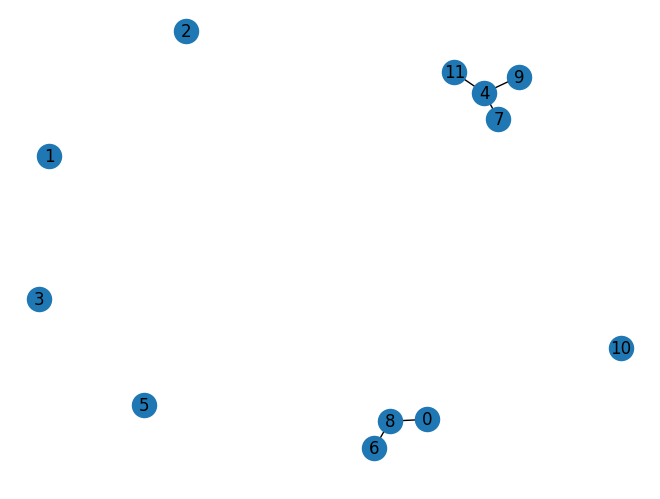

In [89]:
G_diff = nx.difference(pearson_net, gt_pearson_net)
nx.draw(G_diff, with_labels=True)

In [90]:
def calculate_metrics(matrix_actual, matrix_predicted, threshold):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    for i in range(len(matrix_actual)):
        for j in range(len(matrix_actual[0])):
            if matrix_actual[i][j] >= threshold and matrix_predicted[i][j] >= threshold:
                true_positives += 1
            elif matrix_actual[i][j] < threshold and matrix_predicted[i][j] < threshold:
                true_negatives += 1
            elif matrix_actual[i][j] < threshold and matrix_predicted[i][j] >= threshold:
                false_positives += 1
            elif matrix_actual[i][j] >= threshold and matrix_predicted[i][j] < threshold:
                false_negatives += 1

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    
    if true_positives + false_positives == 0:
        precision = 0
    else:
        precision = true_positives / (true_positives + false_positives)

    if true_positives + false_negatives == 0:
        recall = 0
    else:
        recall = true_positives / (true_positives + false_negatives)

    return accuracy, precision, recall

In [91]:
calculate_metrics(pearson, gt_pearson, 0.25)

(0.7361111111111112, 0.2765957446808511, 0.7647058823529411)